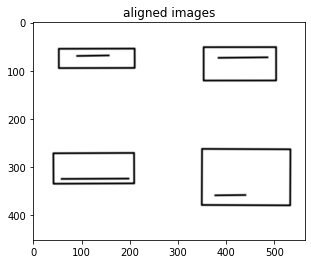

In [82]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

# config------------------------------
IMAGE_PATH = "image.png"
# first rectangle image size 
# is retrieved manually through ms.pain
RECTANGLE_FIRST_SIZE = (200,250)
# coordinate of two endpoints of the base of each rectangles
BASE_LINES = [[(50,75),(209,118)],[(359, 134,), (505,95)],[(203, 291),(56, 375)],[(328, 343), (489, 435)]]


# helper functions------------------------------
def rotate_image(image, angle):  #rotate the image about the given angle around the center of the image
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1],
                            flags=cv2.INTER_LINEAR,
                            borderMode = cv2.BORDER_CONSTANT,
                            borderValue=255)
 
    return result

def get_angle(point1, point2): #return the angle between two points
    base = point2[0] - point1[0]
    perpendicular = point2[1] - point1[1]
    theta = math.degrees(math.atan(perpendicular/base))
    return theta

def align_rectangle(rectangle_images, base_lines_coord):
    """It takes a list of cropped rectangles and a list of each rectangle base lines 
    and returns the list of aligned rectangle images."""
    aligned_rectangles = []
    for rect_img, base_coord in zip(rectangle_images,base_lines_coord):
        theta = get_angle(*base_coord)
        aligned_rectangles.append(rotate_image(rect_img,theta))  
    return aligned_rectangles


def merge_images(final_image_shape,
                 list_images,
                 rectangle_first_size=RECTANGLE_FIRST_SIZE):
    """It merges the given list of aligned rectangular images.
    It takes the shape of the image after merged and list of images"""
    
    merged_image = np.ones(final_image_shape) * 255 # initialize all the pixels are white, it is not mandatory
    merged_image[:rectangle_first_size[0],
                 :rectangle_first_size[1]] = list_images[0]
    merged_image[:rectangle_first_size[0],
                 rectangle_first_size[1]:] = list_images[1]
    merged_image[rectangle_first_size[0]:,
                 :rectangle_first_size[1]] = list_images[2]
    merged_image[rectangle_first_size[0]:,
                 rectangle_first_size[1]:] = list_images[3]
    return merged_image



# main method----------------------------------
def run(show_image = True, save_image = True): 
    # loading image
    image = cv2.imread(IMAGE_PATH)
    # transforming into gray image
    gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    # cropping the image into four different image each of them contains each rectangle of the given figure
    rectangle_first_image = gray_image[:RECTANGLE_FIRST_SIZE[0],:RECTANGLE_FIRST_SIZE[1]]
    rectangle_second_image = gray_image[:RECTANGLE_FIRST_SIZE[0],RECTANGLE_FIRST_SIZE[1]:]
    rectangle_third_image = gray_image[RECTANGLE_FIRST_SIZE[0]:,:RECTANGLE_FIRST_SIZE[1]]
    rectangle_fourth_image = gray_image[RECTANGLE_FIRST_SIZE[0]:,RECTANGLE_FIRST_SIZE[1]:]
    
    rect_images = [rectangle_first_image, rectangle_second_image, rectangle_third_image, rectangle_fourth_image]
    
    # align rectangles
    aligned_rects = align_rectangle(rect_images,BASE_LINES)
    
    # merged all the images of aligned rectangles
    final_image = merge_images(gray_image.shape,aligned_rects)
    
    # save the final aligned image
    if save_image:
        cv2.imwrite("aligned_rectangles.png",final_image)
    
    # display image
    if show_image:
        plt.imshow(final_image,cmap="gray")
        plt.title("aligned images")
        plt.show()
    
if __name__ == '__main__':
    run()
    

# Task 2 (naming the rectangle)

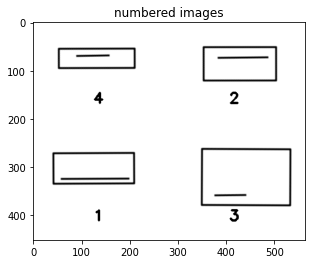

In [87]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

# config------------------------------
IMAGE_PATH = "aligned_rectangles.png"
# first rectangle image size 
# is retrieved manually through ms.pain
RECTANGLE_FIRST_SIZE = (200,250)
# coordinate of two endpoints of the base of each rectangles
BASE_LINES = [[(50,75),(209,118)],[(359, 134,), (505,95)],[(203, 291),(56, 375)],[(328, 343), (489, 435)]]


# helper functions
def calculate_dist(box):
    """Takes box as an input i.e a list of coordinates of 
    4 points of a rectangular box"""
    #p1 (min(x,y)) and p2(min(x,y))
    #distance (p2 - p1)
    p1 = box[0]
    p2 = box[0]
    for point in box:
        if point[0] > p2[0]:
            p2 = point
        if point[0] < p1[0]:
            p1 = point
    return ((p2[0]-p1[0])**2 + (p2[1] - p1[0])**2)**1/2


def find_line_length(image):
    """This function takes cropped image of a rectangle
    returns the length of the inner line of the rectangle
    Note that it uses calculate_dist function
    """
    image = image.astype(np.uint8)
    kernel = np.array([[-1,-1,-1], [-1,10,-1], [-1,-1,-1]])
    image = cv2.filter2D(image, -1, kernel)
    _, thresh = cv2.threshold(image, 127, 255, 0)
    contours, _ = cv2.findContours(thresh, 1,cv2.RETR_TREE)
    #contours 0 contain child contours : an assumption
    cnt = contours[0]
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    return calculate_dist(box)    
    
    
def length_order_encoder(length_list):
    """This function takes a list of numbers particularly a list of distance
    and returns the rank of the distance in descending order
    for instance: a list contains two elements, if the first element is 
    greater that the second then the return encoded list is [1,0]"""
    
    sorted_list = sorted(length_list, reverse=True)
    rank = [1+sorted_list.index(x) for x in length_list ]
    return rank


def merge_images(final_image_shape,
                 list_images,
                 rectangle_first_size=RECTANGLE_FIRST_SIZE):
    """It merges the given list of aligned rectangular images.
    It takes the shape of the image after merged and list of images"""
    
    merged_image = np.ones(final_image_shape) * 255 # initialize all the pixels are white, it is not mandatory
    merged_image[:rectangle_first_size[0],
                 :rectangle_first_size[1]] = list_images[0]
    merged_image[:rectangle_first_size[0],
                 rectangle_first_size[1]:] = list_images[1]
    merged_image[rectangle_first_size[0]:,
                 :rectangle_first_size[1]] = list_images[2]
    merged_image[rectangle_first_size[0]:,
                 rectangle_first_size[1]:] = list_images[3]
    return merged_image


def run(show_image = True, save_image = True):
    # loading aligned image
    image = cv2.imread(IMAGE_PATH)
    # transforming into gray image
    gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    # cropping the image into four different image each of them contains each rectangle of the given figure
    rectangle_first_image = gray_image[:RECTANGLE_FIRST_SIZE[0],:RECTANGLE_FIRST_SIZE[1]]
    rectangle_second_image = gray_image[:RECTANGLE_FIRST_SIZE[0],RECTANGLE_FIRST_SIZE[1]:]
    rectangle_third_image = gray_image[RECTANGLE_FIRST_SIZE[0]:,:RECTANGLE_FIRST_SIZE[1]]
    rectangle_fourth_image = gray_image[RECTANGLE_FIRST_SIZE[0]:,RECTANGLE_FIRST_SIZE[1]:]
    
    rect_images = [rectangle_first_image, rectangle_second_image, rectangle_third_image, rectangle_fourth_image]
    
    # extract the length of the inner line of each rectangle
    length = []
    for rect in rect_images:
        length.append(find_line_length(rect))
    
    # encode the length into ranks 
    length_rank = length_order_encoder(length)
    
    #put the rank test as an image caption
    
    for index,image in enumerate(rect_images):
        cv2.putText(image,str(length_rank[index]),(image.shape[1]//2,image.shape[0]-image.shape[0]//6 ), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 3)
    
    # merged all the images of aligned rectangles
    final_image = merge_images(gray_image.shape,rect_images)
    
    # save the final aligned image
    if save_image:
        cv2.imwrite("numbered_rectangles.png",final_image)
    
    # display image
    if show_image:
        plt.imshow(final_image,cmap="gray")
        plt.title("numbered images")
        plt.show()
        


if __name__ == "__main__":
    run()
    


